In [73]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

In [53]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 KB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.3 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [80]:
df_master = pd.read_parquet('../master/master.parquet')

In [81]:
df_master.iloc[332409]

user_id                                  CSP0983
dateString                              20100104
userDate                        CSP0983_20100104
isEmployed                                     1
isInsider                                      0
hasLogin                                     1.0
firstActivity                                NaN
hasConnect                                   NaN
role                                  Accountant
dateHour                                     8.0
probLogonRole                           0.211338
webCount                                    42.0
countPC                                      1.0
employee_name             Carissa September Pena
psyc_O                                        43
psyc_C                                        27
psyc_E                                        17
psyc_A                                        31
psyc_N                                        27
numMonthsEmployed                             18
sumExtEmailSize     

In [82]:
for colToStd in ['webCount', 'webQuestionableUsage','numExtEmails','sumExtEmailAttachments','sumExtEmailSize']:
    df_roleStd = df_master.groupby('role').apply(lambda x: (x[colToStd] - x[colToStd].mean())/x[colToStd].std()).to_frame()\
    .reset_index(level=0).drop('role', axis=1).rename(columns={colToStd:colToStd+'Std'})
    df_master = df_master.join(df_roleStd)

In [43]:
df_master = pd.get_dummies(df_master, columns=['role'])

In [83]:
df_master = df_master.fillna(0)

In [84]:
df_master.columns

Index(['user_id', 'dateString', 'userDate', 'isEmployed', 'isInsider',
       'hasLogin', 'firstActivity', 'hasConnect', 'role', 'dateHour',
       'probLogonRole', 'webCount', 'countPC', 'employee_name', 'psyc_O',
       'psyc_C', 'psyc_E', 'psyc_A', 'psyc_N', 'numMonthsEmployed',
       'sumExtEmailSize', 'sumExtEmailAttachments', 'numExtEmails',
       'probLogonUser', 'webQuestionableUsage', 'webCountStd',
       'webQuestionableUsageStd'],
      dtype='object')

In [46]:
features = ['isEmployed', 'isInsider',
       'hasLogin', 'firstActivity', 'hasConnect', 'probLogonRole',
       'webCount', 'countPC', 'psyc_O', 'psyc_C', 'psyc_E',
       'psyc_A', 'psyc_N', 'numMonthsEmployed', 'sumExtEmailSize',
       'sumExtEmailAttachments', 'numExtEmails', 'probLogonUser',
       'webQuestionableUsage', 'role_Accountant',
       'role_AdministrativeAssistant', 'role_AdministrativeStaff',
       'role_AssemblySupervisor', 'role_Attorney', 'role_ChiefEngineer',
       'role_ComputerProgrammer', 'role_ComputerScientist',
       'role_ComputerTrainer', 'role_Director', 'role_ElectricalEngineer',
       'role_Engineer', 'role_FieldServiceEngineer', 'role_FinancialAnalyst',
       'role_HardwareEngineer', 'role_HealthSafetyEngineer',
       'role_HumanResourceSpecialist', 'role_ITAdmin',
       'role_IndustrialEngineer', 'role_LabManager', 'role_ManagementTrainer',
       'role_Manager', 'role_MaterialsEngineer', 'role_Mathematician',
       'role_MechanicalEngineer', 'role_Nurse', 'role_NursePractitioner',
       'role_Physicist', 'role_President', 'role_ProductionLineWorker',
       'role_PurchasingClerk', 'role_Salesman', 'role_Scientist',
       'role_SecurityGuard', 'role_SoftwareEngineer', 'role_Statistician',
       'role_SystemsEngineer', 'role_TechnicalTrainer', 'role_Technician',
       'role_TestEngineer', 'role_VicePresident','webCountStd', 'webQuestionableUsageStd']

In [85]:
features = ['isEmployed',
       'hasLogin', 'firstActivity', 'hasConnect', 'probLogonRole', 'countPC', 'psyc_O', 'psyc_C', 'psyc_E',
       'psyc_A', 'psyc_N', 'numMonthsEmployed', 'sumExtEmailSize',
       'sumExtEmailAttachments', 'numExtEmails', 'probLogonUser', 'webCountStd',
       'webQuestionableUsageStd']

In [86]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)

In [87]:
isolation_forest.fit(df_master[df_master['isInsider'] != 1][features])

/home/vzb403/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01)

In [88]:
anomaly_scores = isolation_forest.decision_function(df_master[features])

In [89]:
df_master['anomaly_score'] = anomaly_scores

In [90]:
df_master[df_master['isInsider'] == 1][['user_id','isInsider','anomaly_score']]

,user_id,isInsider,anomaly_score
54149,CSF0929,1,0.097779
54150,CSF0929,1,0.103175
54151,CSF0929,1,0.108215
54152,CSF0929,1,0.112863
54153,CSF0929,1,0.133411
54158,CSF0929,1,0.113813
54159,CSF0929,1,0.116603
54160,CSF0929,1,0.109904
54161,CSF0929,1,0.111649
54166,CSF0929,1,0.107558


<Axes: >

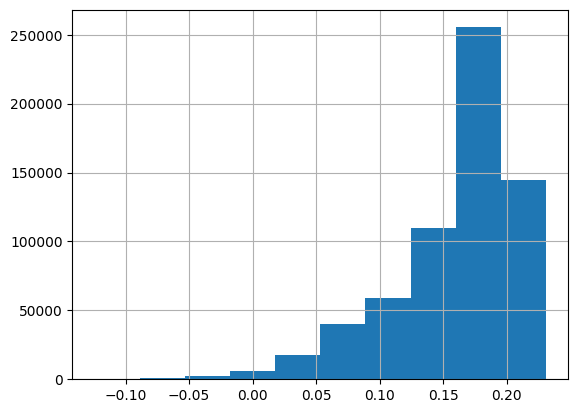

In [91]:
df_master['anomaly_score'].hist()

<Axes: >

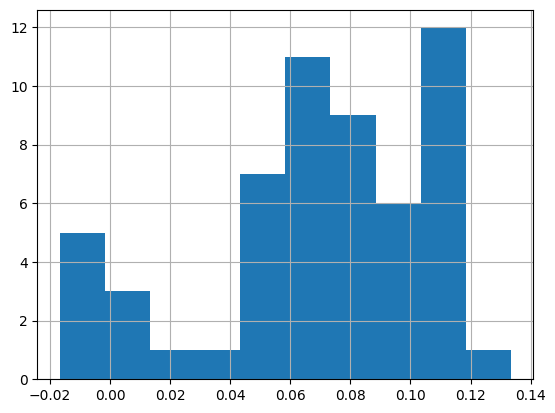

In [92]:
df_master[df_master['isInsider'] == 1]['anomaly_score'].hist()

In [49]:
pd.set_option('display.max_rows', 500)
df_master[df_master['role_ITAdmin'] != 1].nsmallest(10, 'anomaly_score').transpose()

,273494,353599,622854,570550,579837,610506,622798,622853,622797,273650
user_id,LKF0701,TGF0571,MLM0570,EBS0706,BIS0988,KHC0465,MLM0570,MLM0570,MLM0570,LKF0701
dateString,20100315,20100713,20101102,20110413,20101118,20100104,20101001,20101102,20101001,20100811
userDate,LKF0701_20100315,TGF0571_20100713,MLM0570_20101102,EBS0706_20110413,BIS0988_20101118,KHC0465_20100104,MLM0570_20101001,MLM0570_20101102,MLM0570_20101001,LKF0701_20100811
isEmployed,1,1,1,1,1,1,1,1,1,1
isInsider,0,0,0,0,0,0,0,0,0,0
hasLogin,1.0,3.0,2.0,1.0,1.0,1.0,3.0,2.0,3.0,1.0
firstActivity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hasConnect,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
dateHour,6.0,7.0,13.0,7.0,7.0,7.0,18.0,7.0,11.0,7.0
probLogonRole,0.159509,0.270511,0.038683,0.270511,0.278892,0.270511,0.001015,0.270511,0.038119,0.270511


In [93]:
param_grid = {'n_estimators': [50, 100, 150],
              'max_samples': [0.5, 0.7, 0.9],
              'max_features': [0.5, 0.7, 0.9],
              'contamination': [0.01, 0.05, 0.1]}

In [94]:
iso_model = IsolationForest(random_state=42)

In [95]:
grid_search = GridSearchCV(iso_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

In [96]:
grid_search.fit(df_master[features], df_master['isInsider'])

/home/vzb403/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/vzb403/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/vzb403/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/vzb403/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/vzb403/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/vzb403/.local/lib/python3.10/site-packages/sklearn/base.py:

In [78]:
grid_search.best_params_

{'contamination': 0.01,
 'max_features': 0.9,
 'max_samples': 0.5,
 'n_estimators': 150}

In [79]:
grid_search.best_score_

1.1632364410252343e-05